# Práctica 5

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import pandas as pd

Generamos los puntos aleatoriamente, para poder graficar la distribución.

In [4]:
points = np.random.rayleigh(scale=7.53, size=100000)
bins = 160
y, X = np.histogram(points, bins=bins, density=True)

# Since |X| - 1 = |Y| 
X = X[:-1]

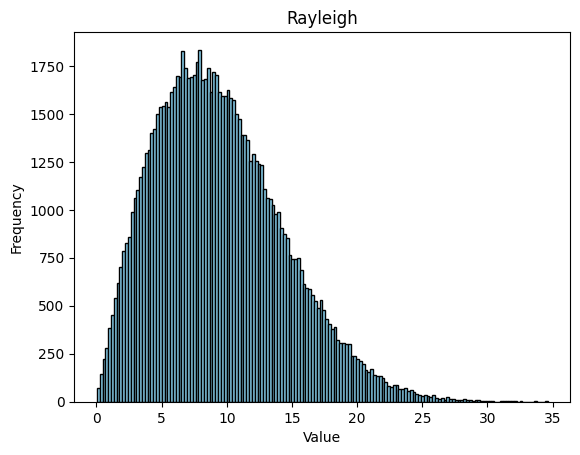

In [9]:
plt.hist(points, bins=bins, color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Rayleigh')

plt.show()

## Generando modelos con regresión polinomial

Vamos a generar modelos usando el entrenamiento tradicional: usar un porcentaje de los datos para entrenar y otro para probar.

In [100]:
def create_metrics_dataframe(
    model, degree, X_test, y_test
):
    '''Creates a dataframe with MSE, R2 and MAE metrics.'''
    
    X_test_poly = calculate_X_poly(X_test, degree)
    y_pred = model.predict(X_test_poly)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    columns = ['MSE', 'R2', 'MAE']
    
    data = [[mse, r2, mae]]
    return pd.DataFrame(data, columns=columns, index=[degree])

def calculate_X_poly(X, degree):
    '''Converts one dimensional X to a polynomial features.'''

    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X.reshape(-1, 1))
    return X_poly

def polynomial_regression(X: np.array, Y: np.array, degree: int):
    '''Creates a polynomial regression model.'''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_poly = calculate_X_poly(X_train, degree)

    model = LinearRegression()
    model.fit(X_poly, y_train)

    df = create_metrics_dataframe(model, degree, X_test, y_test)

    return model, df

Generamos hasta un polinomio de grado 20.

In [141]:
metrics = pd.DataFrame()
for degree in range(1, 20):
    _, model_metrics = polynomial_regression(X, y, degree)
    metrics = pd.concat([metrics, model_metrics])

Visualizamos las métricas de cada modelo de n-dimensiones:

In [107]:
metrics

,MSE,R2,MAE
1,0.000204,0.762580,0.011561
2,0.000241,0.719083,0.013302
3,0.000064,0.926030,0.006378
4,0.000006,0.992930,0.002011
5,0.000006,0.992927,0.002014
6,0.000002,0.997403,0.001044
7,0.000001,0.998479,0.000655
8,0.000001,0.998428,0.000648
9,0.000001,0.998457,0.000605
10,0.000002,0.998114,0.000791


## Creando modelos usando validación cruzada

Usamos KFold para particionar nuestro conjunto de entrenamiento para realizar validación cruzada.

In [159]:
def cv_polinomial_regression(X, y, degree):
    '''Creates a polynomial regression model using cross validation for training.'''

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()

    k_folds = 10
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    X_train_poly = calculate_X_poly(X_train, degree)
    scores = []


    for train_index, test_index in kf.split(X_train_poly):
        X_train_kf, X_test_kf = X_train_poly[train_index], X_train_poly[test_index]
        y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]
        
        model.fit(X_train_kf, y_train_kf)
        scores.append(model.score(X_test_kf, y_test_kf))

    
    df = create_metrics_dataframe(model, degree, X_test, y_test)

    return model, df
    

In [160]:
cv_metrics = pd.DataFrame()
for degree in range(1, 20):
    _, model_metrics = cv_polinomial_regression(X, y, degree)
    cv_metrics = pd.concat([metrics, model_metrics])

In [161]:
cv_metrics

,MSE,R2,MAE
1,0.000204,0.762580,0.011561
2,0.000241,0.719083,0.013302
3,0.000064,0.926030,0.006378
4,0.000006,0.992930,0.002011
5,0.000006,0.992927,0.002014
6,0.000002,0.997403,0.001044
7,0.000001,0.998479,0.000655
8,0.000001,0.998428,0.000648
9,0.000001,0.998457,0.000605
10,0.000002,0.998114,0.000791
